You can install it via pip. Make sure the Python version in your environment matches the requirements which you will find here updated regularly.

In [7]:
!pip install tigramite
!pip install dcor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00


This being done, you can now proceed to import all the packages you need for your analysis (the list below may be more than you need):

In [8]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI

One last remark before we start. We will have to work with a couple of indices here. This can be messy. If we write X(j)_(t-tau) we mean the value of the i-th variable in our system, tau timesteps in the past from the present timestamp t

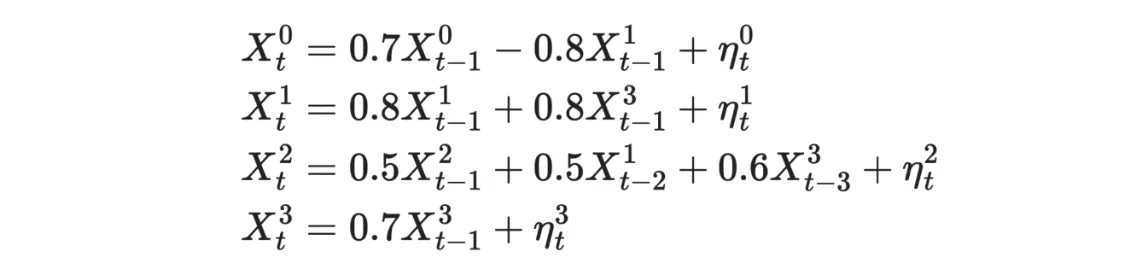

In [10]:
np.random.seed(42)     # Fix random seed to make results reproducable
def lin_f(x): return x # A linear dependency function

links_coeffs = {0: [((0, -1), 0.7, lin_f), ((1, -1), -0.8, lin_f)],
                1: [((1, -1), 0.8, lin_f), ((3, -1), 0.8, lin_f)],
                2: [((2, -1), 0.5, lin_f), ((1, -2), 0.5, lin_f), ((3, -3), 0.6, lin_f)],
                3: [((3, -1), 0.4, lin_f)]} #stores the functional dependencies of the SCM

T = 1000     # time series length
data, true_parents_neighbors = toys.structural_causal_process(links_coeffs, T=T) #generate the timeseries
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data,
                         datatime = {0:np.arange(len(data))},
                         var_names=var_names)

Alright, now that we have generated our data let’s take a look at it with the tp.plot_timeseries function.

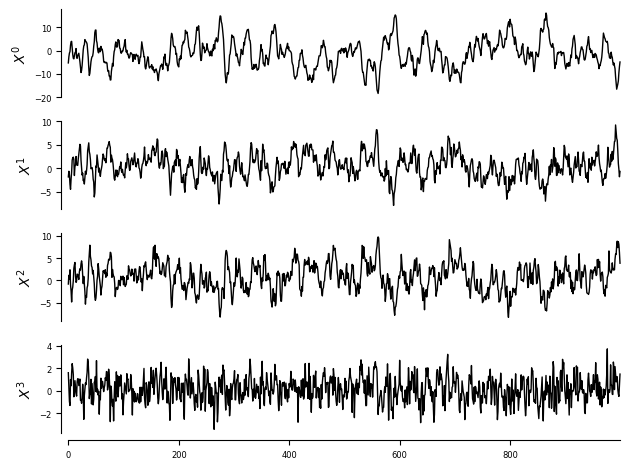

In [11]:
tp.plot_timeseries(dataframe); plt.show()

A quick recap about PCMCI:

Causal Discovery with PCMCI can be split into a process with two phases.

Identifying a superset of the parents for all variables X(j) in the system using a variant of the PC algorithm. As outlined in another blog post, PC is a flexible discovery algorithm, giving us an estimated set of parents per node that can account for nonlinear functional dependencies as well as continuous and discrete variables, depending on the chosen conditional independence test. Phase 1 is a kind of pre-selection step, that will help make the second step more efficient.

Using MCI (Momentary Conditional Independence) to iteratively test conditional independencies. Given our background knowledge about the Causal Markov condition, we know that the causal parents of a variable are a sufficient conditioning set when testing for causal relationships as conditional dependencies because here no instantaneous causal links are assumed. Consequently, we can now use the parents identified in phase one, and use MCI to test whether “X(i)_(t-tau) -> X(j)_t”

Initializing & Running PCMCI

When using PCMCI we have to make a couple of decisions that you probably spotted in the quick recap above or the blog post on PCMCI.

First, we need to choose a conditional independence test for phase 1 and phase 2. Assuming our cause and effects to be linearly dependent we will use the partial correlation test specified with significance=’analytic’ that assumes the null distribution to be Student’s t and then initialize PCMCI using the defined independence test.

In [12]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=parcorr,
    verbosity=1)

The next decision we need to make is to pick the maximum time-lag tau_max on which we expect the longest possible causal link.

Without some theoretical a priori knowledge this decision might be quite hard. What helps here is to plot the lagged correlations of the time series to see at what lag no correlations exist anymore, making those lags irrelevant. This can be done using the following command (where tau_max is chosen to be very large to see a big timeframe):


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


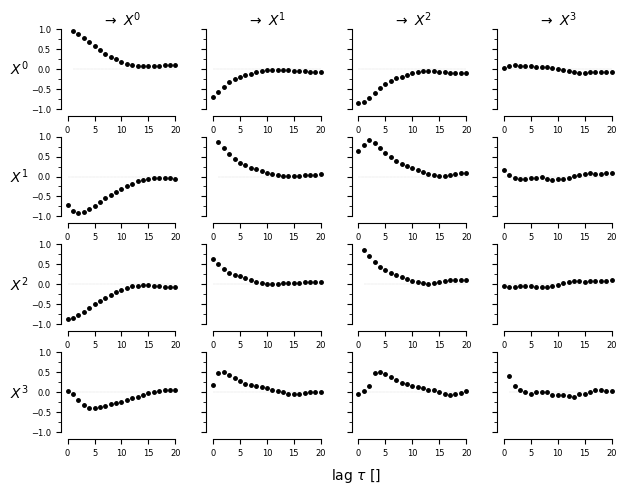

In [13]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations,
                                   setup_args={'var_names':var_names,
                                   'x_base':5, 'y_base':.5}); plt.show()

What we can see from the plots is that the correlations decay at a lag of around 8. Consequently, we pick tau_max=8. If you assume nonlinearities, you would have to use mutual information or a similar measure for this step.

That’s almost it. We now decide what kind of independence test we want to use on what kind of time range. The last thing to determine significant links now is to define when we perceive a dependence to be strong enough such that the null hypothesis can be rejected in the Phase 1 selection step. This significance value is chosen using the parameter pc_alpha, with a default value of 0.05, setting the significance level in the condition-selection step. Instead of just picking one value at random, we can also let PCMCI choose the optimal value by setting it to pc_alpha=None. Then PCMCI will optimize this parameter in the ParCorr case by the Akaike Information criterion among a reasonable default list of values (e.g., pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]). The last remaining parameter we need to specify now is alpha_level=0.01 which indicates that we threshold the resulting p-value matrix in the Phase 2 step at this significance level to obtain the graph.

With this, we are done and can run PCMCI to do the causal discovery for us. You can now run the algorithm and watch what happens:

In [14]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None, alpha_level=0.01)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 8 link(s):
    [pc_alpha = 0.5]
        ($X^0$ -1): max_pval = 0.00000, |min_val| =  0.792
        ($X^1$ -1): max_pval = 0.00000, |min_val| =  0.749
        ($X^3$ -3): max_pval = 0.03223, |min_val| =  0.068
        ($X^2$ -1): max_pval = 0.23374, |min_val| =  0.038
        ($X^1$ -8): max_pval = 0.30383, |min_val| =  0.033
        ($X^2$ -7): max_pval = 0.38595, |min_val| =  0.028
        ($X^2$ -3): max_pval = 0.44412, |min_val| =  0.025
        ($X^1$ -2): max_pval = 0.44578, |min_val| =  0.024

    Variable $X^1$ has 4 link(s):
    [pc_alpha = 0.2]
        ($X^1$ -1): max_pval = 0.00000, |min_val| =  0.699
        ($X^3$ -1): max_pval = 0.00000, |min_val| =  0.485
        ($X^3$ -2): max_pval = 0.00961, 

Interpreting the Output

The output you get is quite long, so let’s make sure we understand what we see.

First, you see an output related to the PC phase. This includes first the parameters you have chosen:

Next, you see the outcomes of the PC1 algorithm. This includes the discovered parents for each variable, sorted by their p-value.

Of course, the parents above are not the final result of PCMCI. They are rather the set we will condition on in the second phase. The second big part of the output shows you the result of the MCI process. The output is again structured similarly to the PC-related output. First, you see the parameters and then the discovered links of each variable sorted by its p-value and described by the latter together with the test statistic value (here partial correlations).

If you look at the test statistic value (val) right now, you might wonder whether it serves as a good indicator of the strength of the causal effect. And your intuition is not misleading, it can indeed be a good indicator. Yet, it does not replace a sound causal effect estimation procedure, which we will discuss in the next article of this series.
Give it some colour

Great, now you have a mess of numbers. Let’s visualize it to make it easier for people to see what kind of message you want to bring across.

To do so Tigramite offers two kinds of plots both being created with very similar functions that take the graph array of the results, the val_matrix and the var_names as inputs. More precisely, you can choose between a time series causal graph or a process causal graph that summarizes the first one. Both can be very helpful depending on what kind of audience you have and if the time-dependency of the process needs to be depicted or not.

If for example, you want to show the causal system you have discovered with respect to its time-dependency, you can plot a time-series graph similar to those that we have discussed in the fundamental blog post about PCMCI:

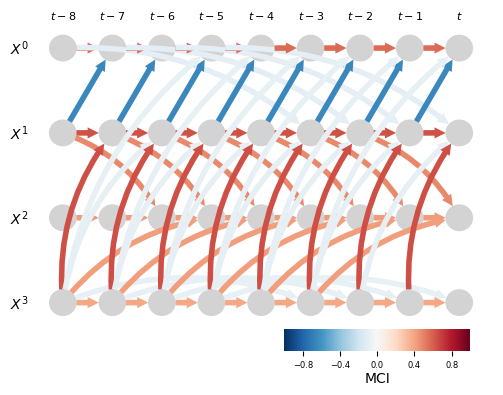

In [21]:
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

As you see above, the ts-graph you obtain will show all the lags for the tau_max you selected. It shows you all the nodes representing the variables at different points in time, with the links between them visualizing the cross-MCI value.

While the ts-graph is undoubtedly more precise and informative regarding the time dependencies between the variables, it is also quite hard to grasp at first glance. This makes it a little disadvantageous when exposing the plot to an audience that is not very knowledgeable in the field of causal inference.

The so-called process graph could help here. It allows you to give a simple overview of your results, with a plot that summarizes the information of a ts-graph into something less crowded. This is achieved by “shaving off” the time-dependencies in the plot:

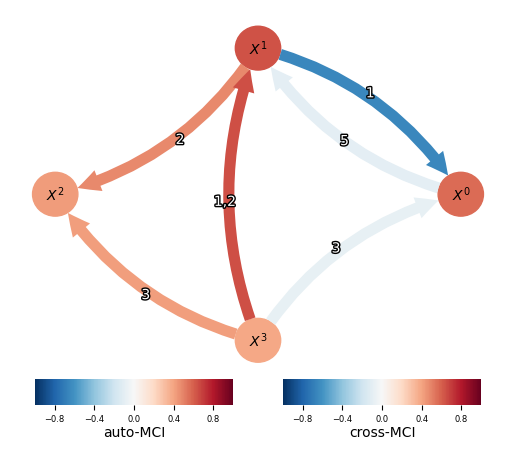

In [22]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

In such process graphs the node color denotes the auto-MCI value and the link colors the cross-MCI value. If links occur at multiple lags between two variables, the link colour denotes the strongest one and the label lists all significant lags in order of their strength, minimizing the information loss although the time dimension is more or less ignored.
Wrapping it up

Congratulations! You have just done your first successful causal discovery in Python and at the same time found a way to analyze and visualize your findings intuitively.

Please be aware though, that your causal discovery is only as good as the data you use and whether it justifies the assumptions you make. If for example, you cannot assume causal sufficiency, interpreting any detected link as existing can be optimistic. Have a look at this guide/review paper for a more in-depth tour of causal discovery.

All in all, the kind of interpretation you can make largely depends on the application scenario. While we have mentioned certain stratagems that all point toward scientific scepticism, there is no real recipe that works all the time. Rather you have to make informed choices based on the data at hand.

Addressing this challenge, Tigramite offers a set of additional algorithms and independence tests that could help you in your specific projects. Tutorials about these tests, algorithms, and caveat stratagems can be found on Tigramite’s GitHub Page.

But wait, that’s not it. Causal Inference is about more than discovering causal links. It is also about estimating the size of the effects right? So once you have discovered a causal graph you are not at the end of the road.